Classification between Apples and Tomatoes with Tensorflow

Importing Libiraries

In [1]:
#importing required libraries
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout


#setting for OOM error by gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
len(gpus)

0

In [2]:
# removing images with other extensions = ['jpg','jpeg','png','bmp'] 
def size_calculator(data_path):
    img_exts = ['jpg','jpeg','png','bmp']
    total_imgs = 0
    total_width = 0
    total_height = 0
    for image_class in os.listdir(data_path):
        for image in os.listdir(os.path.join(data_path,image_class)):
            image_path = os.path.join(data_path,image_class,image)
            
            img = Image.open(image_path)
            tip = img.format.lower()
            if tip not in img_exts:
                print("removing the image {}".format(image_path))
                os.remove(image_path)
            else:
                width,height = img.size
                #add to counter
                total_width += width
                total_height += height
                total_imgs += 1

    #calculating average height and width            
    if total_imgs > 0:
      avg_width = int(total_width/total_imgs)
      avg_height = int(total_height/total_imgs)

    return avg_width,avg_height

            

In [3]:
# data loading and preprocessing
def data_labeler(data_path,ctl):
    dataset_dir = data_path
    class_to_label = ctl
# Initialize lists to store image paths and labels
    image_paths = []
    labels = []

# Iterate over each class
    for class_name in class_to_label:
        class_dir = os.path.join(dataset_dir, class_name)
        for image_filename in os.listdir(class_dir):
            if image_filename.endswith('.jpg') or image_filename.endswith('.png'):
                image_path = os.path.join(class_dir, image_filename)
                image_paths.append(image_path)
                labels.append(class_to_label[class_name])
    return image_paths, labels

In [4]:


def load_and_preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Decode the image from string to uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize the image to a fixed size (e.g., 256x256)
    image = tf.image.resize(image, [256, 256])
    
    # Normalize pixel values to [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label


In [5]:
# Define a function to display a batch of images with labels
def display_images(dataset):
    #creat an iterator
    iterator = iter(dataset)
    batch_images, batch_labels = next(iterator)
    # Convert TensorFlow tensor to numpy array
    images = batch_images.numpy()  
    labels = batch_labels.numpy()
    #plot these images
    plt.figure(figsize=(20, 20))
    batch_size = len(images)
    
    for i in range(4):
        plt.subplot(4, 8, i+1)  
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
        
    plt.show()

In [6]:
#creating data splitter
def data_spliter(dataset):
    #initializing sizes
    train_size = int(len(dataset)*0.7)
    val_size = int(len(dataset)*0.2)
    test_size = int(len(dataset)*0.1)

    test_size += len(dataset) - train_size +val_size +test_size

    #creating train_data
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size+val_size).take(test_size)
    return train,val,test

In [7]:
# model creator function
def model_creator(input_shape,lr=None):
    if lr == None:
        lr = 0.001
    model = tf.keras.Sequential([

        Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',input_shape = input_shape),
        MaxPool2D(),

        Conv2D(32,kernel_size=(3,3),strides=1,activation='relu'),
        MaxPool2D(),

        Conv2D(16,kernel_size=(3,3),strides=1,activation='relu'),
        MaxPool2D(),

        Flatten(),

        Dense(256,activation='relu'),
        Dense(1,activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model
    


Loading, Preprocessing,Displaying Data

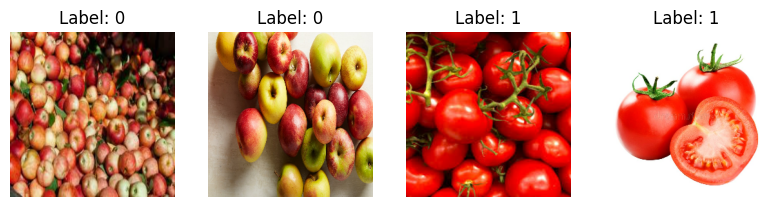

In [8]:
#initializing data path
data_p = os.path.join('data')
class_to_label = {'apples': 0, 'tomatoes': 1}

#removing images
width,height = size_calculator(data_p)
image_path,label = data_labeler(data_p,class_to_label)

# Create a dataset from image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_path, label))
dataset = dataset.map(load_and_preprocess_image)
BATCH_SIZE = 32
dataset = dataset.shuffle(buffer_size=len(image_path))
dataset = dataset.batch(BATCH_SIZE)

#displaying sample images and its labels
display_images(dataset)

#split the data
train_data,val_data,test_data = data_spliter(dataset)



In [9]:
#Hyper parameters
learning_rate = 0.001
epochs = 20

In [10]:
#create model
model = model_creator((256,256,3),learning_rate)
model.summary()

c:\Users\kovarthan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [11]:
logdir = 'log'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_data,epochs=epochs,validation_data=val_data,callbacks=[tensorboard_callback])

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.4536 - loss: 1.6342 - val_accuracy: 0.4531 - val_loss: 0.6959
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.5025 - loss: 0.6922 - val_accuracy: 0.5938 - val_loss: 0.6716
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.5277 - loss: 0.6846 - val_accuracy: 0.5781 - val_loss: 0.6683
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.5026 - loss: 0.6802 - val_accuracy: 0.7344 - val_loss: 0.6624
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.6748 - loss: 0.6699 - val_accuracy: 0.6406 - val_loss: 0.6399
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.7118 - loss: 0.6533 - val_accuracy: 0.7656 - val_loss: 0.6384
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.6812 - loss: 0.6129 - val_accuracy: 0.7344 - val_loss: 0.5544
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.7238 - loss: 0.5642 - val_accuracy: 0.5781 - val_loss:

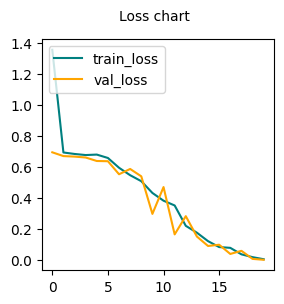

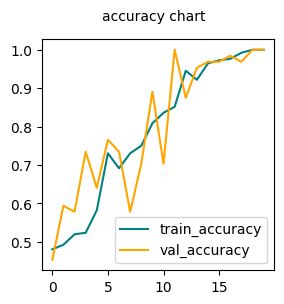

In [12]:
#train evaluation
fig = plt.figure(figsize=(3,3))
plt.plot(hist.history['loss'],color='teal',label='train_loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss chart',fontsize=10)
plt.legend(loc='upper left')

fig2 = plt.figure(figsize=(3,3))
plt.plot(hist.history['accuracy'],color='teal',label='train_accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig2.suptitle('accuracy chart',fontsize=10)
plt.legend(loc='lower right')

In [13]:
from tensorflow.keras.metrics import Precision,BinaryAccuracy,Recall # type: ignore
# define metrics to evaluate


evaluation_results = model.evaluate(test_data,verbose=0)

# Print evaluation results
print("Evaluation results:")
print("Loss:", evaluation_results[0])
print("Accuracy:", evaluation_results[1])


   






Evaluation results:
Loss: 0.002318315440788865
Accuracy: 1.0


In [14]:
def classifier(img_path):
    img = cv2.imread(img_path)
    
    resized_img = tf.image.resize(img, (256, 256))
    
    # Convert the resized image to uint8 format for display
    resized_img = tf.cast(resized_img, tf.uint8)
    
    # Convert BGR (OpenCV format) to RGB (matplotlib format) for display
    rgb_img = cv2.cvtColor(resized_img.numpy(), cv2.COLOR_BGR2RGB)
    
    # Display the resized and converted image using matplotlib
    plt.imshow(rgb_img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

   # preprocess
    data_for_predict = numpy.expand_dims(resized_img/255,0)
    y_predict = model.predict(data_for_predict)
    print(y_predict)

    if y_predict < 0.5: return "apples"
    return "tomatos"


    

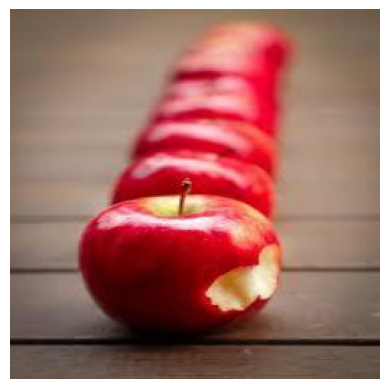

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.641008]]


'tomatos'

In [19]:
im_path = os.path.join('test_apple.jpg')
classifier(im_path)